In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
from diffusion.models.network import ResUNet, get_network
from tqdm.notebook import tqdm
import os
from torchvision import transforms
import json
from datahandler.dataset import NPDataset, make_dataset, RandomRotate90
import matplotlib.pyplot as plt
from diffusion.dm import DiscreteSBM, get_diffusion_model, DiffusionModel
from diffusion.stochastic.sde import DiscreteVPSDE, DiscreteSigmaVPSDE, get_sde, DiscreteSDE
from utils.scheduler import get_optimizer_and_scheduler
import runners as runners

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
N_diff = 1000
amin, amax = -5, 5

In [4]:
train_dataset, test_dataset = make_dataset("CATS_MHD_BPROJ_DENSITY", seed=33, split=0.1)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

In [5]:
sde = DiscreteVPSDE(N_diff)

In [6]:
data = next(iter(train_dataloader))
data = data.to(device)
data = data.unsqueeze(1)
timesteps = (torch.randint(0, 1000, (data.shape[0],))).long().to(device)

x_tilde, mean, noise = sde.sampling(data, timesteps)

The SDE object manages forward time direct sampling (from time 0 to a given time t), as well as the drift, brownian formulation of the SDE. 
It also encompasses methods to do reverse sampling (given a score network, see this[reference]) as well as likelihood computations

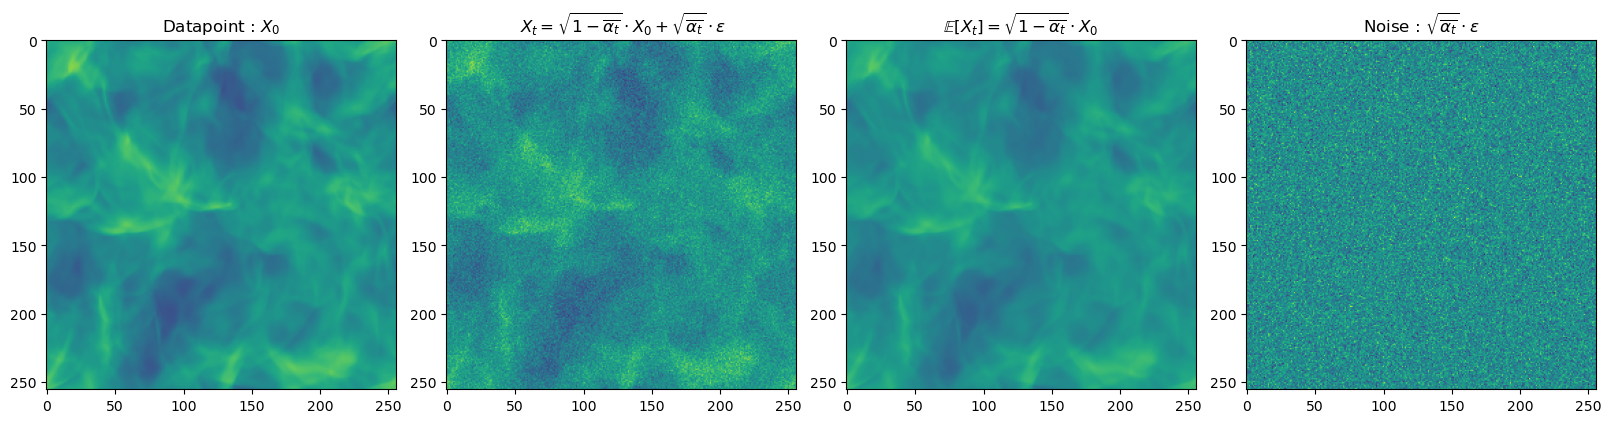

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16,4), layout = 'constrained')
axs[0].imshow(data[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[0].set_title("Datapoint : $X_0$")
axs[1].imshow(x_tilde[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[1].set_title(" $X_t = \sqrt{1-\overline{\\alpha_t}}\cdot X_0 +  \sqrt{\overline{\\alpha_t}}\cdot \epsilon$")
axs[2].imshow(mean[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[2].set_title("$\mathbb{E}[X_t] = \sqrt{1-\overline{\\alpha_t}}\cdot X_0$")
axs[3].imshow(noise[0, 0, :, :].cpu().numpy(),)
axs[3].set_title("Noise : $\sqrt{\overline{\\alpha_t}}\cdot \epsilon$")
plt.show()

In [8]:
network = ResUNet(1, 1, 10, num_blocks=1, n_steps=1000, time_emb_dim=100, dropout=0, attention=[], normalisation="GN", padding_mode="circular", eps_norm=1e-5, skiprescale=True)

TODO add the image?

In [9]:
model = DiscreteSBM(sde, network).to(device)

In [10]:
gen = model.generate_image(sample_size=4, channel=1, size=256)

100%|██████████| 1000/1000 [00:07<00:00, 135.14it/s]


Text(0.5, 0.98, 'Generated images')

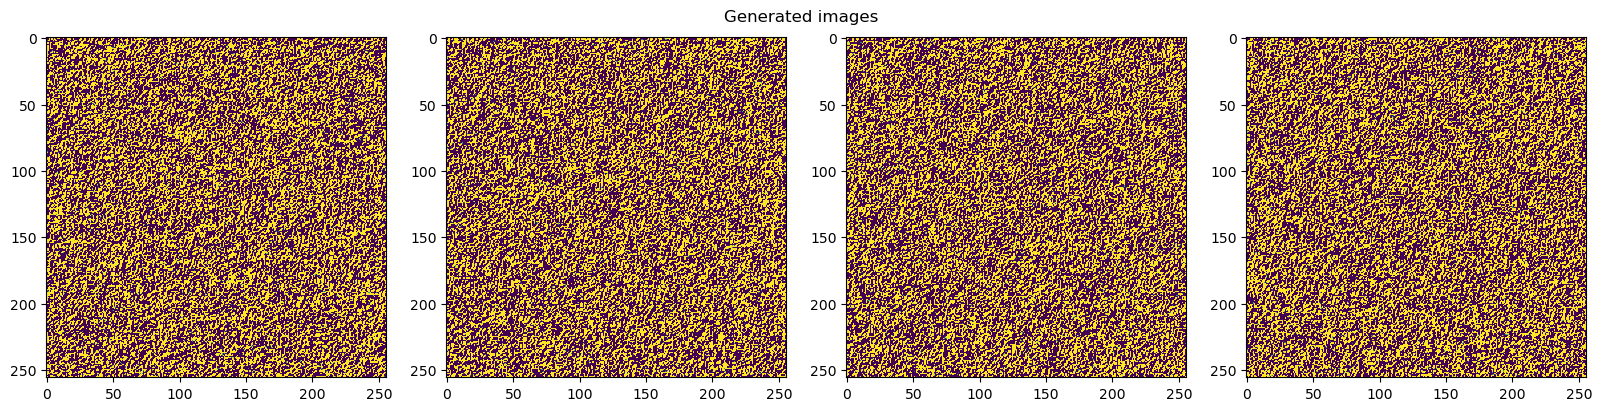

In [11]:
## Plot the generated images
fig, axs = plt.subplots(1, 4, figsize=(16,4), layout = 'constrained')
for i in range(4):
    axs[i].imshow(gen[i, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
fig.suptitle("Generated images")

As you can see, the model is untrained and images that are generated are saturated (compared to the initial dataset). If you were to remove the color bar range, you would see noise.

To generate images, we need to train the network, or get weight from a pretrained model. 

The Diffuser object bundles together a diffusion model (already having the SDE you want to use and an (untrained) network) and tools to make training easier (saving and loading checkpoints, saving and loading architecures through configuration files or dictionnary, generating and saving samples).

In [12]:
diffuser = runners.Diffuser(model, train_dataloader = train_dataloader, test_dataloader = test_dataloader)

Let's see what's inside the diffuser. We provided a model and two dataloaders

In [13]:
diffuser.diffmodel.config

{'sde': {'type': 'DiscreteVPSDE',
  'beta_min': 0.1,
  'beta_max': 20.0,
  'ddpm_math': True,
  'N': 1000},
 'network': {'in_c': 1,
  'out_c': 1,
  'first_c': 10,
  'sizes': [256, 128, 64, 32],
  'num_blocks': 1,
  'n_steps': 1000,
  'time_emb_dim': 100,
  'dropout': 0,
  'attention': [],
  'normalisation': 'GN',
  'padding_mode': 'circular',
  'eps_norm': 1e-05,
  'skiprescale': True,
  'type': 'ResUNet'},
 'type': 'DiscreteSBM'}

In [14]:
diffuser.config["dataloaders"] ## We haven't added any config to the dataloader

{}

#### Training the network



In [15]:
losses, test_losses = diffuser.train(epochs = 25)

No optimizer provided, using Adam with lr=1e-3 and setting the corresponding attr to it.
Epochs provided as argument, using it instead of a possible one as attribute and setting the epochs attribute to it.


Epoch 24: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s, loss=0.0247, step=349]


The training method warns that we have not provided an optimizer, let's ignore that for now as we will touch that in more detail after

diffuser.train() returns the losses and test losses, we can plot them

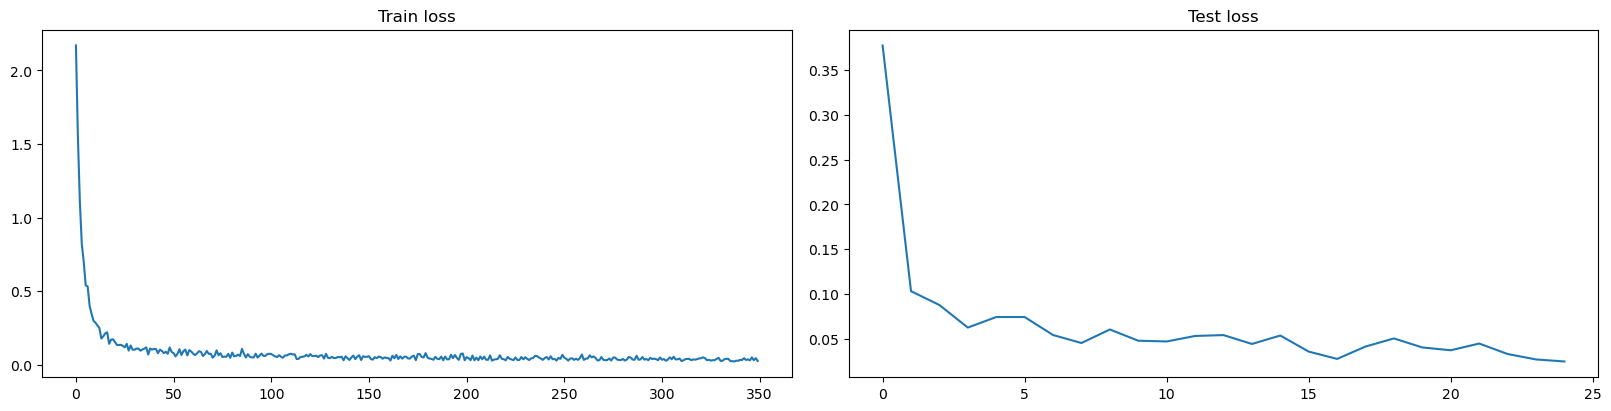

In [16]:
## Plot the losses

fig, axs = plt.subplots(1, 2, figsize=(16,4), layout = 'constrained')
axs[0].plot(losses)
axs[0].set_title("Train loss")
axs[1].plot(test_losses)
axs[1].set_title("Test loss")
plt.show()

We have trained the network for 10 epochs. Let's see generate and print some samples

100%|██████████| 1000/1000 [00:06<00:00, 164.63it/s]


Text(0.5, 0.98, 'Generated images')

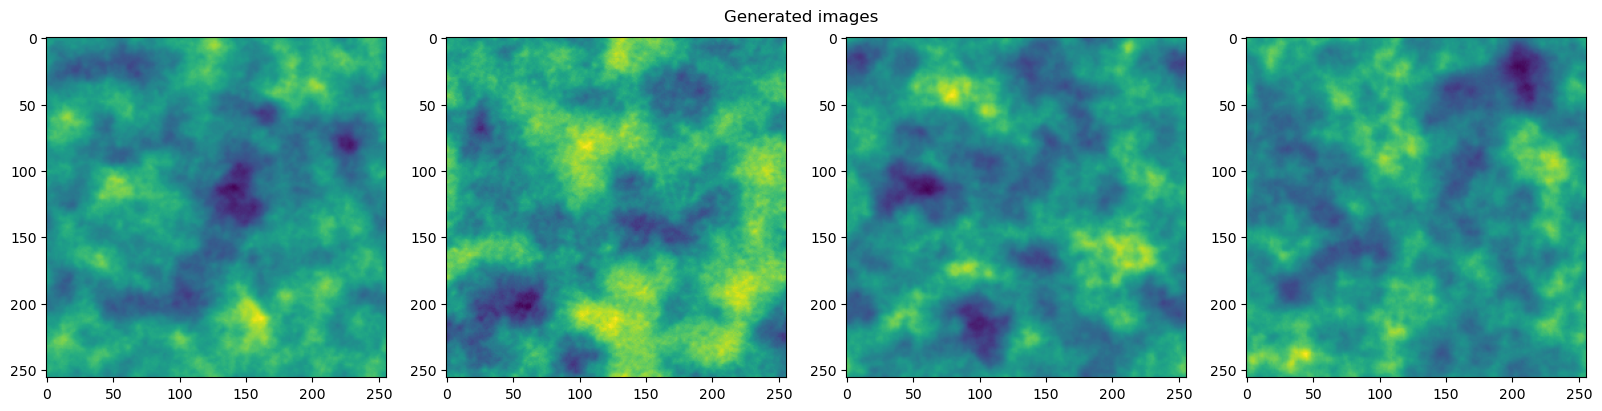

In [17]:
gen = diffuser.diffmodel.generate_image(sample_size=4, channel=1, size=256)

## Plot the generated images
fig, axs = plt.subplots(1, 4, figsize=(16,4), layout = 'constrained')
for i in range(4):
    axs[i].imshow(gen[i, 0, :, :].cpu().numpy(), ) #vmin=amin, vmax=amax
fig.suptitle("Generated images")

We have structure in the images but they are still far from good samples (notice the lack of colorbar normalization). We need to train more. If we do that, we may want to save a checkpoint of the weights every so often (in case training crashes or just to be able to conduct experiments on the model while it's training) and samples as the model is trained to see how they evolve. 

You can do that by adding a checkpoint folder, sample folder and model id to the diffuser, either directly or through set_ckpt_sample. This will create the corresponding folders if they do net exist yet as well as check for conflict with the id. 

If you want to finetune the model from a pretrained version, by now you will have at least loaded weights from a checkpoint. If you loaded the whole configuration all at once, be careful, the model id might still be pointing towards the pretrained model. You do not want to erase its weight so change the model id. Along the way, if you want to keep track of this model, use add_model to put a copy of its configuration, id and both samples and checkpoints folder in the MODELS.json file.

#### More detail on how the diffuser works

In addition to a diffusion model (attribute diffmodel), one can add to the diffuser:
- an optimizer. For now, only Adam, AdamW and SGD are implemented
- a learning rate scheduler to adapt the learning rate of the optimizer during training
- at least a train_dataloader supplying the training examples. 
- an optional but highly recommended test_dataloader.
- attributes and object to manage logging, checkpointing and sampling

The easiest way to load all of these is by specifying a configuration (filepath or dictionnary) or a diffuser id at initialization OR to initialize the diffuser and then call the load method with either a config =  or model_id = argument.

### INITIALIZING WITH ALL PARAMETERS IS THE CLEANEST WAY AND ENSURE THE DIFFUSER BEHAVES THE WAY YOU EXPECT

You avoid having shadow existing parameters that play a role but never appear in the config file

In [34]:
## Method 1:
diffuser = runners.Diffuser(model, model_id="DefaultDDPM")
## Method 2:
# diffuser = runners.Diffuser(model)
# diffuser.load(model_id="DefaultDDPM")

Model id was provided at initialization. Attributes provided along it as args may be overwritten. Loading config (and possibly ckpt) corresponding to the model id: DefaultDDPM

Loading a whole diffuser given a model id. The MODELS.json dict value associated to the id should contain all the config elements. This method will change the model architecture, optimizer, dataset, etc. to match the saved model then load the corresponding states.
Loading the diffuser from a config dict or json file.


As explicitely indicated, ckpt_dir and model_id were found in the config but no ckpt corresponding to model_id was found in ckpt_dir. Therefore, no weights are loaded.

For now, everything in this model is pointing towards the DefaultDDPM diffuser. We will create a new diffuser id just for this one, train it and then save the ckpt. After that, we will see how to load back the checkpoint to resume training, fine tune or generate samples

In [35]:
diffuser.set_model_id("TestSBM_DDPM")

Model id was changed from DefaultDDPM to TestSBM_DDPM.


In [37]:
diffuser.get_config()["model_id"]

'TestSBM_DDPM'

As we explained above, it is possible to reuse weights from another network **that has the same structure**. You can do that using two methods. If there is enough information in the configuration (at initialization or loading) to find one, the corresponding checkpoint will be loaded. The other way is with the *load_ckpt()* method by providing either a *path* (path = ) or a *dictionnary* (ckpt_dict = ). The last argument possible is *for_training*. If for training is True and there are training informations in the checkpoint, those are loaded and added as attributes of the diffuser. Only use this option if you wish to resume training or fine tune the model. The most import elements then are the weights of the optimizer (in the case of Adam variants) and the epoch number (to avoid jumps in the learning rate).

By DEFAULT, for_training is false for pretrained models.

reset optim

Among logging attributes is the option to add a WandB or a TensorBoard logging system (NOT IMPLEMENTED YET) as well as a ckpt_dir and sample_dir. When you save the model (see bellow)